This code produces statistics via violin and line plots of the CMIP6 model ITCZ states (1980-2014) compared to IMERG ITCZ states (1998-2024). In particular, the purpose of these analyses is to determine the season of interest with largest ITCZ biases for further analyses. The code also determines three groups of CMIP6 models based on reanlaysis spread (top group) and a set threshold determined by the user (intermediate or bottom group).

In [1]:
#Author: Alex Gonzalez
#Date: November 2025
#Paper: JGR-Atmospheres

Figure 7. Monthly mean distribution of ITCZ states across all CMIP6 models (1980–2014,
represented by violins, where width is proportional to the amount of data at particular ITCZ state
percentages), IMERG combined microwave and IR observations (MW+IR, 1998–2024, solid black
curves), and the median of all reanalyses (dashed black curves) for: a) nITCZ, b) sITCZ, c) aITCZ,
d) dITCZ, and e) eITCZ. Panel f shows the ITCZ state error averaged over all five ITCZ states for
each CMIP6 model member (blue semi-transparent curves), the CMIP6 model median (solid black
curve), and reanalysis median (dashed black curve) compared to IMERG (MW+IR) observations.

Figure 8. ITCZ state error in CMIP6 models (1980–2014) compared to IMERG combined
microwave and IR observations (MW+IR, 1998–2024) averaged over all months and over all five
ITCZ states (black curves) and over only nITCZ (transparent green curves), sITCZ (transparent
gold curves), aITCZ (transparent blue curves), dITCZ (transparent red curves), and eITCZ (transparent
gray curves). The cyan shading represents the range of ITCZ state error of all reanalyses
averaged over all five ITCZ states (1998–2024). For panel a, the vertical gray lines denote the
cutoffs separating the three CMIP6 model groups: top models (n=2), intermediate models (n=12),
and bottom models (n=11).

Figure 9. Monthly mean ITCZ states in IMERG combined microwave and IR observations
(MW+IR, solid black curves) and the median of reanalyses (dashed black curves), top CMIP6
models group (n=2, solid blue curves), intermediate CMIP6 models group (n=12, solid gold curves),
and bottom CMIP6 models group (n=11, solid red curves).

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
dataset = ['IMERG','BCC-CSM2-MR',
            'CAMS-CSM1-0',
            'CESM2',
            'CESM2-WACCM',
            'CMCC-CM2-HR4',
            'CMCC-CM2-SR5',
            'CMCC-ESM2',
            'CNRM-CM6-1-HR',
            'E3SM-1-0',
            'E3SM-2-0',
            'E3SM-2-0-NARRM',
            'EC-Earth3',
            'EC-Earth3-AerChem',
            'EC-Earth3-CC',
            'EC-Earth3-Veg',
            'EC-Earth3-Veg-LR',
            'FGOALS-f3-L',
            'GFDL-CM4',
            'GFDL-ESM4',
            'HadGEM3-GC31-MM',
            'MPI-ESM1-2-HR',
            'MRI-ESM2-0',
            'NorESM2-MM',
            'SAM0-UNICON',
            'TaiESM1']

In [4]:
len(dataset)

26

In [5]:
nmon = 12
month = np.arange(1,nmon+1,1)

month_xr = xr.DataArray(month, coords=[month], dims=['month'])
datasets_xr = xr.DataArray(dataset, coords=[dataset], dims=['dataset'])

ndataset = len(dataset)
ndataset

26

In [17]:
# region of interest
#region = 'Atlantic'
#region_str = 'Atlantic Ocean'

region = 'EastPac'
region_str = 'East Pacific Ocean'

In [7]:
rain_thresh_str = '5.0mm'
yr0 = 1998
yrf = 2024

model_bias_thresh = 10 
# percentage ITCZ bias threshold set by the user – highest for Central Pac
# (might want to see ITCZ state errors plotted first)

In [8]:
dataset_reana = ['ERA5','MERRA-2','JRA-3Q','CFSR']
ndataset_reana = len(dataset_reana)

folders = ['ERA5_1deg','MERRA-2','JRA-3Q','CFSR']

In [9]:
prc_dITCZ_reana = np.zeros((ndataset_reana,nmon))
prc_nITCZ_reana = np.zeros((ndataset_reana,nmon))
prc_sITCZ_reana = np.zeros((ndataset_reana,nmon))
prc_aITCZ_reana = np.zeros((ndataset_reana,nmon))
prc_eITCZ_reana = np.zeros((ndataset_reana,nmon))
for jj in range(0,ndataset_reana,1):
    dri = '/srv/lss/'+folders[jj]+'/total_precip/'
    fni = dataset_reana[jj]+'_ITCZ_st_daily_'+region+'_abs_thresh_'+rain_thresh_str+'.nc'

    data = xr.open_dataset(dri+fni, engine='netcdf4')
    time_all = data['time']

    for mm in range(0,nmon,1):
        # set up conditional statements 
        cond1 = time_all['time.month'] == month[mm] # season of interest
        cond2 = (time_all['time.year'] >= yr0) & (time_all['time.year'] <= yrf)
        # now find only the times for year(s) and season of interest 
        time = time_all.where(cond1 & cond2, drop=True)
        ndays = len(time)
        #print(ndays)
        
        itcz_state_mon = data['itcz_state'].where(cond1 & cond2, drop=True)
        #print(itcz_state_mon[:10].values)

        cond_dITCZ = (itcz_state_mon == 1)
        cond_nITCZ = (itcz_state_mon == 2)
        cond_sITCZ = (itcz_state_mon == 3)
        cond_aITCZ = (itcz_state_mon == 4)
        cond_eITCZ = (itcz_state_mon == 5)

        itcz_dI = itcz_state_mon.where((cond_dITCZ), drop=True)
        itcz_nI = itcz_state_mon.where((cond_nITCZ), drop=True)
        itcz_sI = itcz_state_mon.where((cond_sITCZ), drop=True)
        itcz_aI = itcz_state_mon.where((cond_aITCZ), drop=True)
        itcz_eI = itcz_state_mon.where((cond_eITCZ), drop=True)
        
        #print(itcz_nI.values)
        #if np.isnan(itcz_dI).all() == True:
            #prc_dITCZ[jj,mm] = 0
        #else:
            #prc_dITCZ[jj,mm] = round(len(itcz_dI)/(ndays)*100.,1)

        #if np.isnan(itcz_nI).all() == True:
            #prc_nITCZ[jj,mm] = 0
        #else:
            #print(len(itcz_nI)/(ndays)*100.)
            #prc_nITCZ[jj,mm] = len(itcz_nI)/(ndays)*100.,1    
            
        prc_dITCZ_reana[jj,mm] = round(len(itcz_dI)/(ndays)*100.,1)
        prc_nITCZ_reana[jj,mm] = round(len(itcz_nI)/(ndays)*100.,1)
        prc_sITCZ_reana[jj,mm] = round(len(itcz_sI)/(ndays)*100.,1)
        prc_aITCZ_reana[jj,mm] = round(len(itcz_aI)/(ndays)*100.,1)
        prc_eITCZ_reana[jj,mm] = round(len(itcz_eI)/(ndays)*100.,1)

In [10]:
prc_dITCZ_reana

array([[ 0. ,  1.8, 11.4, 13.7,  1.9,  0.1,  0. ,  0. ,  0. ,  0. ,  0.1,
         0. ],
       [ 0.1,  0.8,  6.9, 12.1,  1.4,  0.2,  0. ,  0. ,  0.4,  0. ,  0. ,
         0.1],
       [ 1. ,  4.6, 23.9, 31.7,  2.7,  0.5,  0.2,  0. ,  0. ,  0.1,  0.1,
         0.2],
       [ 0.7,  4.8, 25.6, 35.7,  5.6,  2.5,  1.1,  0.1,  0.4,  0. ,  0.1,
         0.5]])

In [11]:
prc_nITCZ_reana_xr = xr.DataArray(prc_nITCZ_reana, coords=[dataset_reana,month], dims=['dataset','month'])
prc_sITCZ_reana_xr = xr.DataArray(prc_sITCZ_reana, coords=[dataset_reana,month], dims=['dataset','month'])
prc_dITCZ_reana_xr = xr.DataArray(prc_dITCZ_reana, coords=[dataset_reana,month], dims=['dataset','month'])
prc_aITCZ_reana_xr = xr.DataArray(prc_aITCZ_reana, coords=[dataset_reana,month], dims=['dataset','month'])
prc_eITCZ_reana_xr = xr.DataArray(prc_eITCZ_reana, coords=[dataset_reana,month], dims=['dataset','month'])

In [12]:
prc_dITCZ = np.zeros((ndataset,nmon))
prc_nITCZ = np.zeros((ndataset,nmon))
prc_sITCZ = np.zeros((ndataset,nmon))
prc_aITCZ = np.zeros((ndataset,nmon))
prc_eITCZ = np.zeros((ndataset,nmon))
for jj in range(0,ndataset,1):
    if dataset[jj] == 'IMERG':
        dri = '/srv/lss/IMERG_1deg/total_precip/'
        fni = dataset[jj]+'_ITCZ_st_daily_'+region+'_abs_thresh_'+rain_thresh_str+'.nc'
    else:
        dri = '/srv/lss/CMIP6_precip_1deg/'+dataset[jj]+'/'
        fni = dataset[jj]+'_ITCZ_st_daily_'+region+'_abs_thresh_'+rain_thresh_str+'.nc'

    data = xr.open_dataset(dri+fni, engine='netcdf4')
    time_all = data['time']

    for mm in range(0,nmon,1):
        # set up conditional statements 
        cond = time_all['time.month'] == month[mm] # season of interest
        # now find only the times for year(s) and season of interest 
        time = time_all.where(cond, drop=True)
        ndays = len(time)
        
        itcz_state_mon = data['itcz_state'].where(cond, drop=True)
        #print(itcz_state_mon[:10].values)

        cond_dITCZ = (itcz_state_mon == 1)
        cond_nITCZ = (itcz_state_mon == 2)
        cond_sITCZ = (itcz_state_mon == 3)
        cond_aITCZ = (itcz_state_mon == 4)
        cond_eITCZ = (itcz_state_mon == 5)


        itcz_dI = itcz_state_mon.where((cond_dITCZ), drop=True)
        itcz_nI = itcz_state_mon.where((cond_nITCZ), drop=True)
        itcz_sI = itcz_state_mon.where((cond_sITCZ), drop=True)
        itcz_aI = itcz_state_mon.where((cond_aITCZ), drop=True)
        itcz_eI = itcz_state_mon.where((cond_eITCZ), drop=True)
    
            
        prc_dITCZ[jj,mm] = round(len(itcz_dI)/(ndays)*100.,1)
        prc_nITCZ[jj,mm] = round(len(itcz_nI)/(ndays)*100.,1)
        prc_sITCZ[jj,mm] = round(len(itcz_sI)/(ndays)*100.,1)
        prc_aITCZ[jj,mm] = round(len(itcz_aI)/(ndays)*100.,1)
        prc_eITCZ[jj,mm] = round(len(itcz_eI)/(ndays)*100.,1)

In [13]:
prc_dITCZ_xr = xr.DataArray(prc_dITCZ, coords=[dataset,month], dims=['dataset','month'])

In [14]:
prc_nITCZ_xr = xr.DataArray(prc_nITCZ, coords=[dataset,month], dims=['dataset','month'])
prc_sITCZ_xr = xr.DataArray(prc_sITCZ, coords=[dataset,month], dims=['dataset','month'])
prc_aITCZ_xr = xr.DataArray(prc_aITCZ, coords=[dataset,month], dims=['dataset','month'])
prc_eITCZ_xr = xr.DataArray(prc_eITCZ, coords=[dataset,month], dims=['dataset','month'])

In [15]:
month_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [25]:
prc_nITCZ_flat = prc_nITCZ_xr[1:,:].stack(z=('month','dataset')).reset_index('z')
prc_nITCZ_flat[:25]

<xarray.DataArray (z: 25)>
array([ 6.6,  3.8, 74.5, 86.5,  2.5, 55.5, 69.8, 11.7, 54.7, 58.2, 43.8,
       37.7, 37.1, 34.7, 33.8, 26.5, 64.7, 32.9, 16.4, 69.1, 30. , 49.6,
       87.7, 92.3, 53.7])
Coordinates:
    month    (z) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    dataset  (z) <U17 'BCC-CSM2-MR' 'CAMS-CSM1-0' ... 'SAM0-UNICON' 'TaiESM1'
Dimensions without coordinates: z

In [26]:
nrows = len(prc_nITCZ_flat)
nrows

300

In [27]:
big_obj = np.zeros((int(nrows),3),dtype=object)
big_obj_sI = np.zeros((int(nrows),3),dtype=object)
big_obj_dI = np.zeros((int(nrows),3),dtype=object)
big_obj_aI = np.zeros((int(nrows),3),dtype=object)
big_obj_eI = np.zeros((int(nrows),3),dtype=object)
cc = 0
for mm in range(0,nmon,1):
    big_obj[cc:cc+ndataset-1,0] = prc_nITCZ_xr[1:,mm]
    big_obj[cc:cc+ndataset-1,1] = dataset[1:]
    big_obj[cc:cc+ndataset-1,2] = month[mm]

    big_obj_sI[cc:cc+ndataset-1,0] = prc_sITCZ_xr[1:,mm]
    big_obj_sI[cc:cc+ndataset-1,1] = dataset[1:]
    big_obj_sI[cc:cc+ndataset-1,2] = month[mm]

    big_obj_dI[cc:cc+ndataset-1,0] = prc_dITCZ_xr[1:,mm]
    big_obj_dI[cc:cc+ndataset-1,1] = dataset[1:]
    big_obj_dI[cc:cc+ndataset-1,2] = month[mm]

    big_obj_aI[cc:cc+ndataset-1,0] = prc_aITCZ_xr[1:,mm]
    big_obj_aI[cc:cc+ndataset-1,1] = dataset[1:]
    big_obj_aI[cc:cc+ndataset-1,2] = month[mm]

    big_obj_eI[cc:cc+ndataset-1,0] = prc_eITCZ_xr[1:,mm]
    big_obj_eI[cc:cc+ndataset-1,1] = dataset[1:]
    big_obj_eI[cc:cc+ndataset-1,2] = month[mm]
    cc = cc + ndataset-1

In [28]:
big_pd = pd.DataFrame(data=big_obj,columns=['nITCZ (%)','model','month']).infer_objects()
big_pd

,nITCZ (%),model,month
0,6.6,BCC-CSM2-MR,1
1,3.8,CAMS-CSM1-0,1
2,74.5,CESM2,1
3,86.5,CESM2-WACCM,1
4,2.5,CMCC-CM2-HR4,1
...,...,...,...
295,88.5,MPI-ESM1-2-HR,12
296,86.0,MRI-ESM2-0,12
297,95.4,NorESM2-MM,12
298,95.9,SAM0-UNICON,12


In [29]:
big_pd_sI = pd.DataFrame(data=big_obj_sI,columns=['sITCZ (%)','model','month']).infer_objects()
big_pd_dI = pd.DataFrame(data=big_obj_dI,columns=['dITCZ (%)','model','month']).infer_objects()
big_pd_aI = pd.DataFrame(data=big_obj_aI,columns=['aITCZ (%)','model','month']).infer_objects()
big_pd_eI = pd.DataFrame(data=big_obj_eI,columns=['eITCZ (%)','model','month']).infer_objects()

In [30]:
print(prc_nITCZ_xr[1:].max())
print(prc_nITCZ_xr[1:].min())

<xarray.DataArray ()>
array(100.)
<xarray.DataArray ()>
array(0.)


In [31]:
mon_str = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [32]:
prc_dITCZ_reana_xr.median(dim=('dataset'))

<xarray.DataArray (month: 12)>
array([ 0.4 ,  3.2 , 17.65, 22.7 ,  2.3 ,  0.35,  0.1 ,  0.  ,  0.2 ,
        0.  ,  0.1 ,  0.15])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

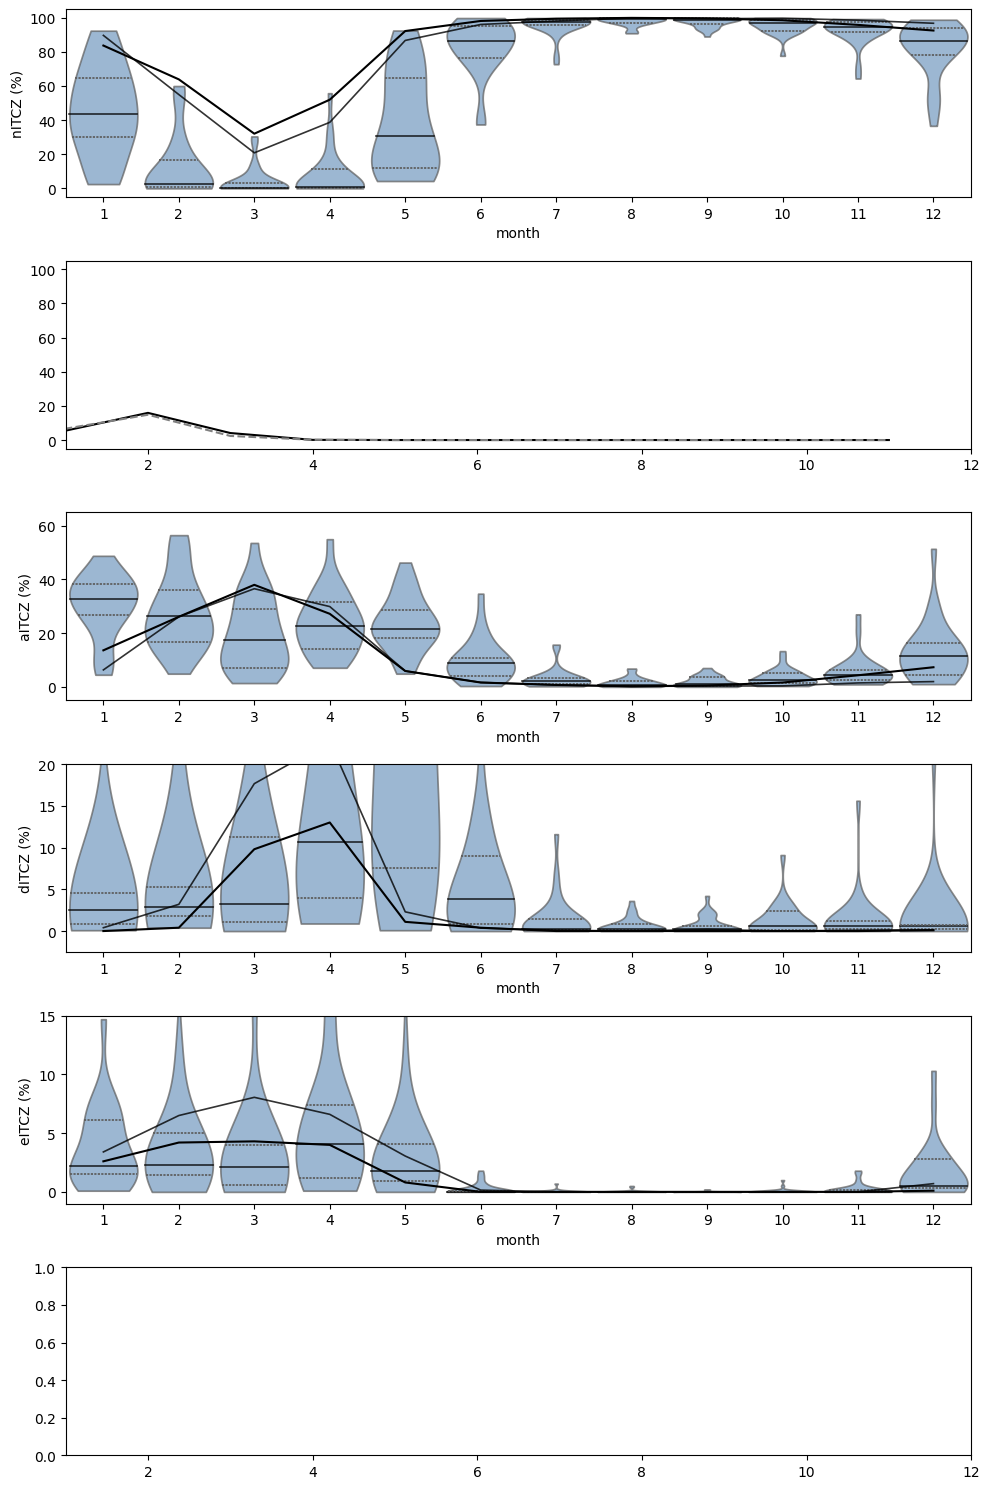

In [33]:
npan = nmon
import pandas
import seaborn as sns

npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 15), tight_layout='true')
for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    plt.xlim(1,12) 
    if jj == 0:
        ax = sns.violinplot(x='month', y='nITCZ (%)', data=big_pd, color='#6699CC', cut=0, width=0.9, inner='quart', legend=False, density_norm='width') #,showmeans=False,showmedians=True)
        plt.ylim(-5,105)
        plt.setp(ax.collections, alpha=.7)
        ax2 = ax.plot(prc_nITCZ_xr[0,:],color='k',label='TMPA')
        ax3 = ax.plot(prc_nITCZ_reana_xr.median(dim=('dataset')),color='grey',linestyle=':',label='Reanalysis median')
        for l in ax.lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.2)
            l.set_color('black')
            l.set_alpha(0.8)
    if jj == 1:
        #ax = sns.violinplot(x='month', y='sITCZ (%)', data=big_pd_sI, color='#6699CC', cut=0, width=0.9, inner='quart', legend=False, density_norm='width') #,showmeans=False,showmedians=True)
        plt.ylim(-5,105)
        #plt.setp(ax.collections, alpha=.7)
        ax2 = ax.plot(prc_sITCZ_xr[0,:],color='k',label='TMPA')
        ax3 = ax.plot(prc_sITCZ_reana_xr.median(dim=('dataset')),color='grey',linestyle='--',label='Reanalysis median')
        #for l in ax.lines[1::3]:
            #l.set_linestyle('-')
            #l.set_linewidth(1.2)
            #l.set_color('black')
            #l.set_alpha(0.8)
    if jj == 2:
        ax = sns.violinplot(x='month', y='aITCZ (%)', data=big_pd_aI, color='#6699CC', cut=0, width=0.9, inner='quart', legend=False, density_norm='width') #,showmeans=False,showmedians=True)
        #ax.set_alpha(0.5)
        plt.ylim(-5,65)
        plt.setp(ax.collections, alpha=.7)
        ax2 = ax.plot(prc_aITCZ_xr[0,:],color='k',label='TMPA')
        ax3 = ax.plot(prc_aITCZ_reana_xr.median(dim=('dataset')),color='grey',linestyle='--',label='Reanalysis median')
        for l in ax.lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.2)
            l.set_color('black')
            l.set_alpha(0.8)
    if jj == 3:
        ax = sns.violinplot(x='month', y='dITCZ (%)', data=big_pd_dI, color='#6699CC', cut=0, width=0.9, inner='quart', legend=False, density_norm='width') #,showmeans=False,showmedians=True)
        #ax.set_alpha(0.5)
        plt.ylim(-2.5,20)
        plt.setp(ax.collections, alpha=.7)
        ax2 = ax.plot(prc_dITCZ_xr[0,:],color='k',label='TMPA')
        ax3 = ax.plot(prc_dITCZ_reana_xr.median(dim=('dataset')),color='grey',linestyle='--',label='Reanalysis median')
        for l in ax.lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.2)
            l.set_color('black')
            l.set_alpha(0.8)
    if jj == 4:
        ax = sns.violinplot(x='month', y='eITCZ (%)', data=big_pd_eI, color='#6699CC', cut=0, width=0.9, inner='quart', legend=False, density_norm='width') #,showmeans=False,showmedians=True)
        #ax.set_alpha(0.5)  
        plt.ylim(-1,15)  
        plt.setp(ax.collections, alpha=.7)
        ax2 = ax.plot(prc_eITCZ_xr[0,:],color='k',label='TMPA')
        ax3 = ax.plot(prc_eITCZ_reana_xr.median(dim=('dataset')),color='grey',linestyle='--',label='Reanalysis median')
        for l in ax.lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.2)
            l.set_color('black')
            l.set_alpha(0.8)
#plt.axhline(0, color='0.65', linewidth = 2.0, zorder=-1
#ax.set_title(month_str[mm], loc='left')

In [34]:
month

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [35]:
prc_dITCZ_reana_xr.median(dim=('dataset'))

<xarray.DataArray (month: 12)>
array([ 0.4 ,  3.2 , 17.65, 22.7 ,  2.3 ,  0.35,  0.1 ,  0.  ,  0.2 ,
        0.  ,  0.1 ,  0.15])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [36]:
prc_nITCZ_median = prc_nITCZ_xr[1:,:].median(dim=('dataset'))
prc_nITCZ_mean = prc_nITCZ_xr[1:,:].mean(dim=('dataset'))
prc_nITCZ_std = prc_nITCZ_xr[1:,:].std(dim=('dataset'))

prc_sITCZ_median = prc_sITCZ_xr[1:,:].median(dim=('dataset'))
prc_sITCZ_mean = prc_sITCZ_xr[1:,:].mean(dim=('dataset'))
prc_sITCZ_std = prc_sITCZ_xr[1:,:].std(dim=('dataset'))

prc_dITCZ_median = prc_dITCZ_xr[1:,:].median(dim=('dataset'))
prc_dITCZ_mean = prc_dITCZ_xr[1:,:].mean(dim=('dataset'))
prc_dITCZ_std = prc_dITCZ_xr[1:,:].std(dim=('dataset'))

prc_aITCZ_median = prc_aITCZ_xr[1:,:].median(dim=('dataset'))
prc_aITCZ_mean = prc_aITCZ_xr[1:,:].mean(dim=('dataset'))
prc_aITCZ_std = prc_aITCZ_xr[1:,:].std(dim=('dataset'))

prc_eITCZ_median = prc_eITCZ_xr[1:,:].median(dim=('dataset'))
prc_eITCZ_mean = prc_eITCZ_xr[1:,:].mean(dim=('dataset'))
prc_eITCZ_std = prc_eITCZ_xr[1:,:].std(dim=('dataset'))

In [37]:
prc_nITCZ_anom = prc_nITCZ_xr - prc_nITCZ_xr[0,:]  
prc_sITCZ_anom = prc_sITCZ_xr - prc_sITCZ_xr[0,:]  
prc_dITCZ_anom = prc_dITCZ_xr - prc_dITCZ_xr[0,:]  
prc_aITCZ_anom = prc_aITCZ_xr - prc_aITCZ_xr[0,:]  
prc_eITCZ_anom = prc_eITCZ_xr - prc_eITCZ_xr[0,:]  

In [38]:
prc_ITCZ_anom_abs = (np.fabs(prc_nITCZ_anom) + np.fabs(prc_sITCZ_anom) + np.fabs(prc_dITCZ_anom) + np.fabs(prc_aITCZ_anom) + np.fabs(prc_eITCZ_anom))/5

prc_ITCZ_anom_ann = prc_ITCZ_anom_abs.mean(dim=('month'))
prc_ITCZ_anom_sea = prc_ITCZ_anom_abs[:,:5].mean(dim=('month'))

In [39]:
prc_ITCZ_anom_snI = (np.fabs(prc_nITCZ_anom) + np.fabs(prc_sITCZ_anom))/2


In [40]:
prc_ITCZ_anom_abs_median = prc_ITCZ_anom_abs[1:,:].median(dim='dataset')

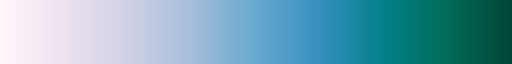

In [41]:
levp = np.arange(-12., 13., 1.)
color_map = plt.colormaps['PuBuGn']
color_map

In [42]:
n = 30
colors = color_map(np.linspace(0, 1, n))
colors

array([[1.        , 0.96862745, 0.98431373, 1.        ],
       [0.9812995 , 0.94795848, 0.97348712, 1.        ],
       [0.96026144, 0.92470588, 0.96130719, 1.        ],
       [0.93922338, 0.90145329, 0.94912726, 1.        ],
       [0.91472511, 0.87973856, 0.9373318 , 1.        ],
       [0.88372165, 0.86091503, 0.92625913, 1.        ],
       [0.85616301, 0.84418301, 0.91641676, 1.        ],
       [0.82515955, 0.82535948, 0.9053441 , 1.        ],
       [0.783391  , 0.80422914, 0.8935025 , 1.        ],
       [0.73688581, 0.78208381, 0.88132257, 1.        ],
       [0.69038062, 0.75993849, 0.86914264, 1.        ],
       [0.64032295, 0.73779316, 0.85679354, 1.        ],
       [0.57831603, 0.71810842, 0.8449827 , 1.        ],
       [0.50855825, 0.69596309, 0.8316955 , 1.        ],
       [0.43880046, 0.67381776, 0.8184083 , 1.        ],
       [0.37679354, 0.64890427, 0.80346021, 1.        ],
       [0.32253749, 0.62122261, 0.78685121, 1.        ],
       [0.26828143, 0.59354095,

In [43]:
prc_ITCZ_anom_abs_timmean = prc_ITCZ_anom_abs.mean(dim='month')
prc_ITCZ_anom_abs_sort = prc_ITCZ_anom_abs.sortby(prc_ITCZ_anom_abs_timmean, ascending=False)

In [44]:
prc_nITCZ_anom_reana = prc_nITCZ_reana_xr - prc_nITCZ_xr.sel(dataset='IMERG')
prc_sITCZ_anom_reana = prc_sITCZ_reana_xr - prc_sITCZ_xr.sel(dataset='IMERG')
prc_dITCZ_anom_reana = prc_dITCZ_reana_xr - prc_dITCZ_xr.sel(dataset='IMERG')
prc_aITCZ_anom_reana = prc_aITCZ_reana_xr - prc_aITCZ_xr.sel(dataset='IMERG')
prc_eITCZ_anom_reana = prc_eITCZ_reana_xr - prc_eITCZ_xr.sel(dataset='IMERG')

In [45]:
prc_nITCZ_abs_reana = np.fabs(prc_nITCZ_anom_reana)
prc_sITCZ_abs_reana = np.fabs(prc_sITCZ_anom_reana)
prc_aITCZ_abs_reana = np.fabs(prc_aITCZ_anom_reana)
prc_dITCZ_abs_reana = np.fabs(prc_dITCZ_anom_reana)
prc_eITCZ_abs_reana = np.fabs(prc_eITCZ_anom_reana)

In [46]:
# Biases between reanalyses and TMPA summed over all ITCZ states first
prc_abs_reanal = (prc_nITCZ_abs_reana+prc_sITCZ_abs_reana+prc_aITCZ_abs_reana+prc_dITCZ_abs_reana+prc_eITCZ_abs_reana)/5

# Now take the median of the all the mdoels biases
prc_abs_reanal_median = prc_abs_reanal.median(dim='dataset')#.plot()

In [47]:
prc_abs_reanal_median

<xarray.DataArray (month: 12)>
array([3.11, 3.88, 6.47, 6.46, 2.4 , 0.98, 0.53, 0.07, 0.28, 0.55, 1.32,
       2.2 ])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [48]:
prc_eITCZ_reana_xr

<xarray.DataArray (dataset: 4, month: 12)>
array([[ 3.5,  5.8,  7. ,  6. ,  1.2,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ,
         0.4],
       [ 3.3,  5.1,  5.7,  5.4,  2.2,  0. ,  0. ,  0. ,  0.1,  0. ,  0. ,
         0.4],
       [ 4.2,  9.3, 13.6, 10. ,  5.9,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ,
         1.1],
       [ 2.6,  7.2,  9.1,  7.2,  3.9,  0.4,  0. ,  0. ,  0. ,  0. ,  0. ,
         1. ]])
Coordinates:
  * dataset  (dataset) <U7 'ERA5' 'MERRA-2' 'JRA-3Q' 'CFSR'
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

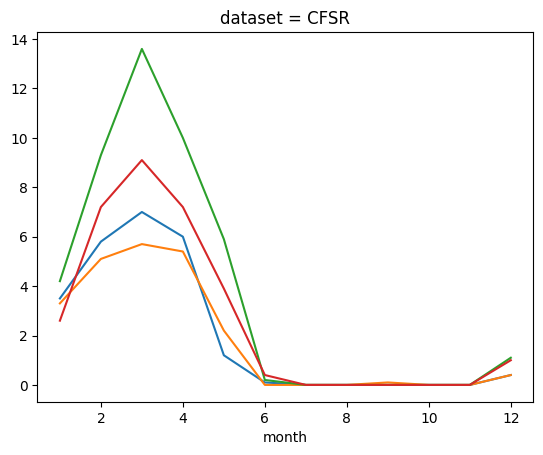

In [49]:
prc_eITCZ_reana_xr[0,:].plot()
prc_eITCZ_reana_xr[1,:].plot()
prc_eITCZ_reana_xr[2,:].plot()
prc_eITCZ_reana_xr[3,:].plot()

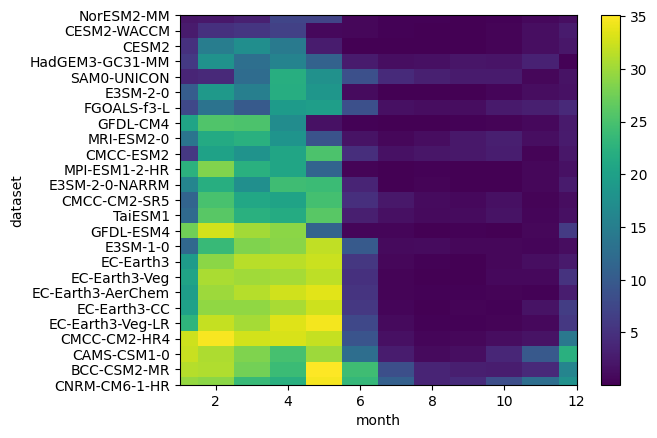

In [50]:
prc_ITCZ_anom_abs_sort[:-1,:].plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


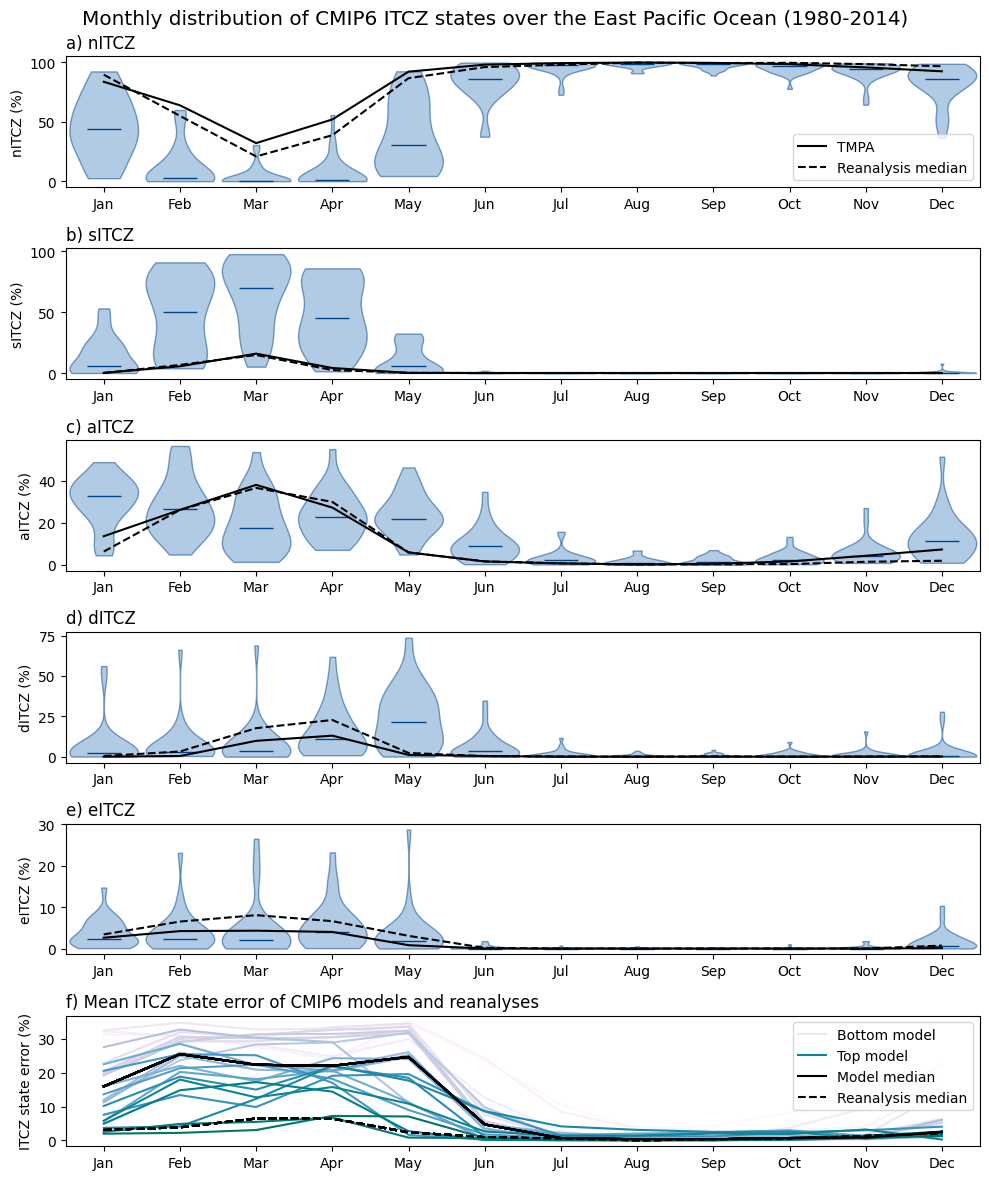

In [51]:
npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of CMIP6 models and reanalyses', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(prc_nITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_nITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.legend(loc=4)
        plt.ylabel('nITCZ (%)')
        #plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(prc_sITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_sITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('sITCZ (%)')
        #plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(prc_aITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_aITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('aITCZ (%)')
        #plt.ylim(-5,65)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(prc_dITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_dITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('dITCZ (%)')
        #plt.ylim(-2,65)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(prc_eITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_eITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('eITCZ (%)')
        #plt.ylim(-1,20)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

plt.savefig(figfolder+figname1,bbox_inches="tight",transparent=False,dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


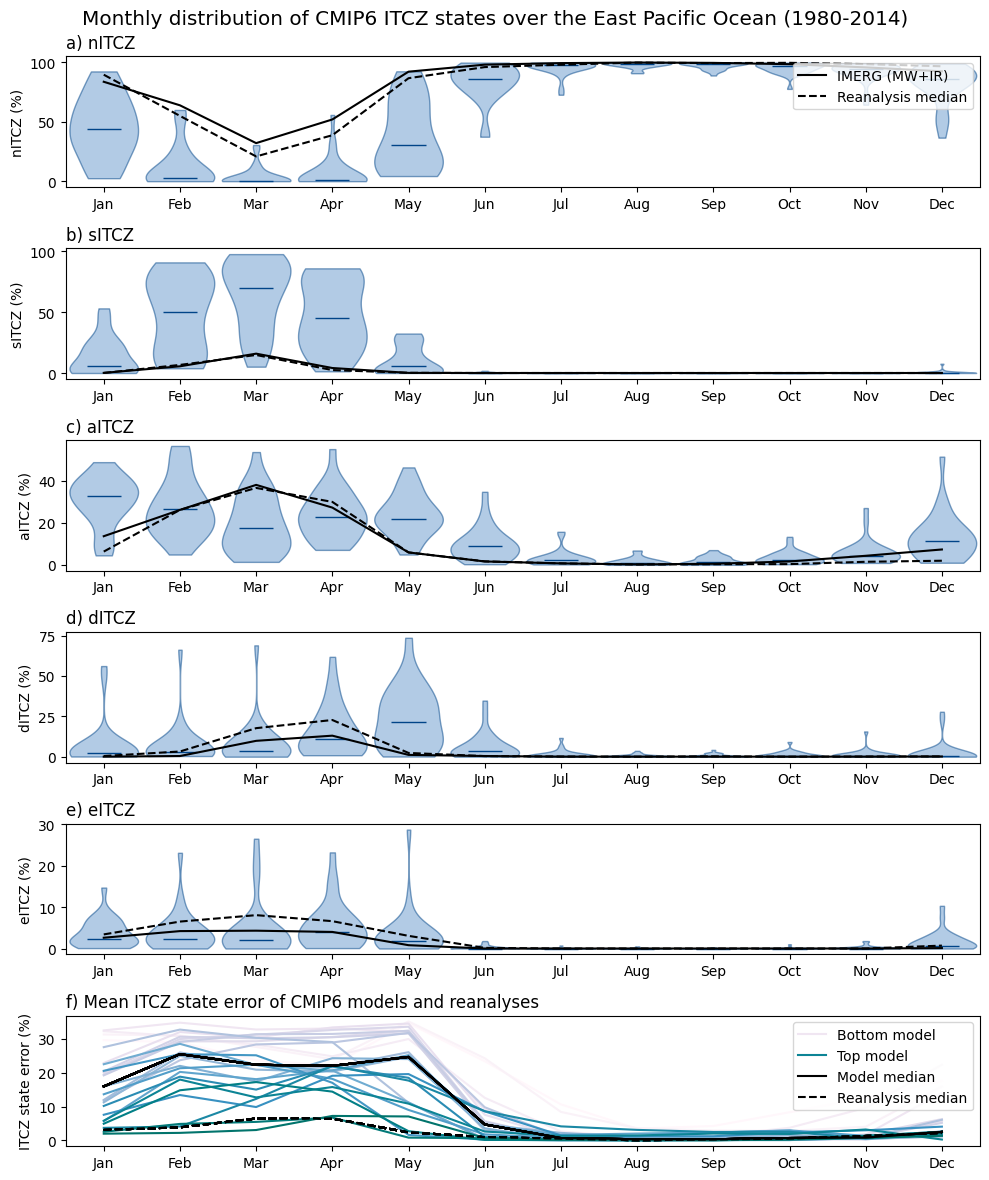

In [52]:
npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of CMIP6 models and reanalyses', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(prc_nITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_nITCZ[0,:],color='k',label='IMERG (MW+IR)')
        ax3 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.legend(loc=1)
        plt.ylabel('nITCZ (%)')
        #plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(prc_sITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_sITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('sITCZ (%)')
        #plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(prc_aITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_aITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('aITCZ (%)')
        #plt.ylim(-5,65)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(prc_dITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_dITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('dITCZ (%)')
        #plt.ylim(-2,75)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(prc_eITCZ[1:,:],showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_eITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('eITCZ (%)')
        #plt.ylim(-1,20)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
plt.savefig(figfolder+'ITCZ_state_'+region+'_CMIP6_stats.pdf',bbox_inches="tight",transparent=False,dpi=150)

In [53]:
#idmonth = [0,1,2,3,4,5,11]
#idmonth = [0,1,2,3,4]
idmonth = np.arange(0,12)

model_bias = prc_ITCZ_anom_abs_sort[:-1,idmonth].mean(dim='month')
reanl_bias = prc_abs_reanal[:,idmonth].mean(dim='month')
reanl_bias_max = reanl_bias.max()

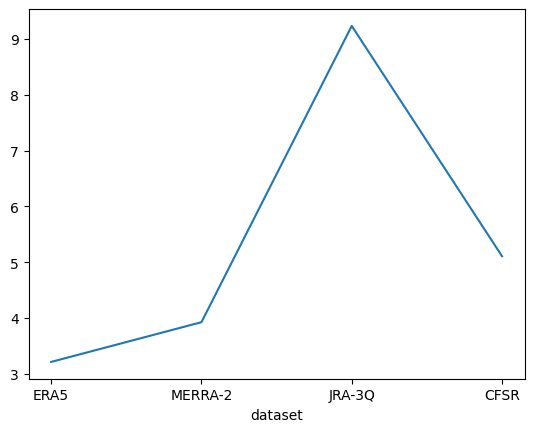

In [179]:
reanl_bias.plot()

In [54]:
model_top = model_bias['dataset'].where(model_bias<=reanl_bias_max,drop=True)
model_intermed = model_bias['dataset'].where((model_bias>reanl_bias_max) & (model_bias<=model_bias_thresh),drop=True)
model_bot = model_bias['dataset'].where((model_bias>model_bias_thresh),drop=True)

In [55]:
model_shoulder = model_bias['dataset'].where((model_bias>model_bias_thresh) & (model_bias<=15),drop=True)
model_worst = model_bias['dataset'].where((model_bias>15),drop=True)

In [56]:
model_top

<xarray.DataArray 'dataset' (dataset: 2)>
array(['CESM2-WACCM', 'NorESM2-MM'], dtype=object)
Coordinates:
  * dataset  (dataset) <U17 'CESM2-WACCM' 'NorESM2-MM'

In [57]:
model_intermed.sortby(model_intermed)

<xarray.DataArray 'dataset' (dataset: 12)>
array(['CESM2', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'E3SM-2-0', 'E3SM-2-0-NARRM',
       'FGOALS-f3-L', 'GFDL-CM4', 'HadGEM3-GC31-MM', 'MPI-ESM1-2-HR',
       'MRI-ESM2-0', 'SAM0-UNICON', 'TaiESM1'], dtype=object)
Coordinates:
  * dataset  (dataset) <U17 'CESM2' 'CMCC-CM2-SR5' ... 'SAM0-UNICON' 'TaiESM1'

In [58]:
model_bot.sortby(model_bot)

<xarray.DataArray 'dataset' (dataset: 11)>
array(['BCC-CSM2-MR', 'CAMS-CSM1-0', 'CMCC-CM2-HR4', 'CNRM-CM6-1-HR',
       'E3SM-1-0', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'GFDL-ESM4'], dtype=object)
Coordinates:
  * dataset  (dataset) <U17 'BCC-CSM2-MR' 'CAMS-CSM1-0' ... 'GFDL-ESM4'

In [60]:
prc_ITCZ_anom_snI_sorted = prc_ITCZ_anom_snI[1:].sel(dataset=model_bias['dataset'])#.sortby(dataset=model_bias['dataset'])

In [61]:
prc_ITCZ_anom = prc_abs_reanal.mean(dim=('month')).median()#prc_abs_reanal_median.mean()
prc_ITCZ_anom

<xarray.DataArray ()>
array(2.97)

In [62]:
itcz_state = ['nITCZ','sITCZ','aITCZ','dITCZ','eITCZ']
nitcz_state = len(itcz_state)
itcz_state_xr = xr.DataArray(itcz_state,coords=[itcz_state],dims=['itcz_state'])
prc_ITCZ_CMIP6_errors_np = np.zeros((ndataset-1,nmon,nitcz_state))

In [63]:
prc_nITCZ_plt = np.fabs(prc_nITCZ_anom[1:,:]).sel(dataset=model_bias['dataset'])
prc_sITCZ_plt = np.fabs(prc_sITCZ_anom[1:,:]).sel(dataset=model_bias['dataset'])
prc_dITCZ_plt = np.fabs(prc_dITCZ_anom[1:,:]).sel(dataset=model_bias['dataset'])
prc_aITCZ_plt = np.fabs(prc_aITCZ_anom[1:,:]).sel(dataset=model_bias['dataset'])
prc_eITCZ_plt = np.fabs(prc_eITCZ_anom[1:,:]).sel(dataset=model_bias['dataset'])

In [64]:
prc_ITCZ_CMIP6_errors_np[:,:,0] = prc_nITCZ_plt
prc_ITCZ_CMIP6_errors_np[:,:,1] = prc_sITCZ_plt
prc_ITCZ_CMIP6_errors_np[:,:,2] = prc_aITCZ_plt
prc_ITCZ_CMIP6_errors_np[:,:,3] = prc_dITCZ_plt
prc_ITCZ_CMIP6_errors_np[:,:,4] = prc_eITCZ_plt

In [65]:
prc_ITCZ_CMIP6_errors_xr = xr.DataArray(prc_ITCZ_CMIP6_errors_np,coords=[model_bias['dataset'],month_xr,itcz_state_xr],dims=['dataset_CMIP6','month','itcz_state'])

In [66]:
prc_ITCZ_CMIP6_errors_xr.name = 'error_CMIP6'
prc_ITCZ_CMIP6_errors_xr.attrs['long_name'] = 'ITCZ state error'
prc_ITCZ_CMIP6_errors_xr.attrs['standard_name'] = 'itcz_state_error'
prc_ITCZ_CMIP6_errors_xr.attrs['units'] = '%'
prc_ITCZ_CMIP6_errors_xr.attrs['obs'] = 'IMERG (MW+IR)'
prc_ITCZ_CMIP6_errors_xr.attrs['comment'] = 'CMIP6 models in order of smallest to largest errors'

In [67]:
prc_ITCZ_reana_errors_np = np.zeros((ndataset_reana,nmon,nitcz_state))
prc_ITCZ_reana_errors_np[:,:,0] = prc_nITCZ_abs_reana
prc_ITCZ_reana_errors_np[:,:,1] = prc_sITCZ_abs_reana
prc_ITCZ_reana_errors_np[:,:,2] = prc_aITCZ_abs_reana
prc_ITCZ_reana_errors_np[:,:,3] = prc_dITCZ_abs_reana
prc_ITCZ_reana_errors_np[:,:,4] = prc_eITCZ_abs_reana

In [68]:
prc_ITCZ_reana_errors_xr = xr.DataArray(prc_ITCZ_reana_errors_np,coords=[dataset_reana,month_xr,itcz_state_xr], dims=['dataset_reana','month','itcz_state'])

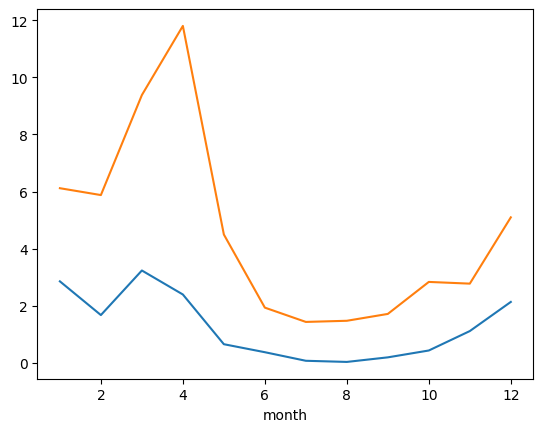

In [69]:
prc_ITCZ_reana_errors_xr.mean(dim=('itcz_state')).min(dim=('dataset_reana')).plot()
prc_ITCZ_reana_errors_xr.mean(dim=('itcz_state')).max(dim=('dataset_reana')).plot()

In [70]:
prc_ITCZ_reana_errors_xr.name = 'error_reana'
prc_ITCZ_reana_errors_xr.attrs['long_name'] = 'ITCZ state error'
prc_ITCZ_reana_errors_xr.attrs['standard_name'] = 'itcz_state_error'
prc_ITCZ_reana_errors_xr.attrs['units'] = '%'
prc_ITCZ_reana_errors_xr.attrs['obs'] = 'IMERG (MW+IR)'

In [71]:
# now output errors as a function of month of year for reanalyses and CMIP6 models for each region
data_final = xr.merge([prc_ITCZ_CMIP6_errors_xr,prc_ITCZ_reana_errors_xr])

In [75]:
data_final

<xarray.Dataset>
Dimensions:        (dataset_CMIP6: 25, month: 12, itcz_state: 5,
                    dataset_reana: 4)
Coordinates:
  * dataset_CMIP6  (dataset_CMIP6) <U17 'CNRM-CM6-1-HR' ... 'NorESM2-MM'
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * itcz_state     (itcz_state) <U5 'nITCZ' 'sITCZ' 'aITCZ' 'dITCZ' 'eITCZ'
  * dataset_reana  (dataset_reana) <U7 'ERA5' 'MERRA-2' 'JRA-3Q' 'CFSR'
Data variables:
    error_CMIP6    (dataset_CMIP6, month, itcz_state) float64 71.9 2.7 ... 0.1
    error_reana    (dataset_reana, month, itcz_state) float64 6.8 0.1 ... 0.9
Attributes:
    long_name:      ITCZ state error
    standard_name:  itcz_state_error
    units:          %
    obs:            IMERG (MW+IR)
    comment:        CMIP6 models in order of smallest to largest errors

In [76]:
fld_out = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/scripts/methods_paper/data/'
fno = 'ITCZ_errors_'+region+'.nc'
data_final.to_netcdf(path=fld_out+fno)

In [77]:
prc_ITCZ_CMIP6_errors_all_plt = prc_ITCZ_CMIP6_errors_xr.mean(dim=('itcz_state')).mean(dim=('month'))
prc_ITCZ_CMIP6_errors_plt = prc_ITCZ_CMIP6_errors_xr.mean(dim=('month'))
prc_ITCZ_reana_errors_plt = prc_ITCZ_reana_errors_xr.mean(dim=('itcz_state')).mean(dim=('month'))
prc_ITCZ_reana_errors_min = prc_ITCZ_reana_errors_plt.min()
prc_ITCZ_reana_errors_max = prc_ITCZ_reana_errors_plt.max()

In [78]:
ymax = prc_ITCZ_CMIP6_errors_plt.max()*0.97

In [79]:
prc_ITCZ_CMIP6_errors_all_plt

<xarray.DataArray 'error_CMIP6' (dataset_CMIP6: 25)>
array([18.26      , 17.575     , 16.60333333, 16.14166667, 14.08      ,
       13.02833333, 13.02166667, 12.93      , 12.86333333, 11.59833333,
       11.57      ,  9.83      ,  9.49666667,  9.26333333,  9.02333333,
        8.84166667,  8.11      ,  7.83166667,  7.63      ,  7.43166667,
        6.92666667,  6.33833333,  4.86333333,  2.165     ,  2.09833333])
Coordinates:
  * dataset_CMIP6  (dataset_CMIP6) <U17 'CNRM-CM6-1-HR' ... 'NorESM2-MM'

In [80]:
grad_error = np.fabs(np.diff(prc_ITCZ_CMIP6_errors_all_plt))

In [81]:
prc_diff_sort = np.sort(grad_error)

In [82]:
prc_diff_sort[-3:]

array([1.74      , 2.06166667, 2.69833333])

In [83]:
colors_color_blind = ['#228833','#CCBB44','#4477AA','#EE6677','k']
#['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']

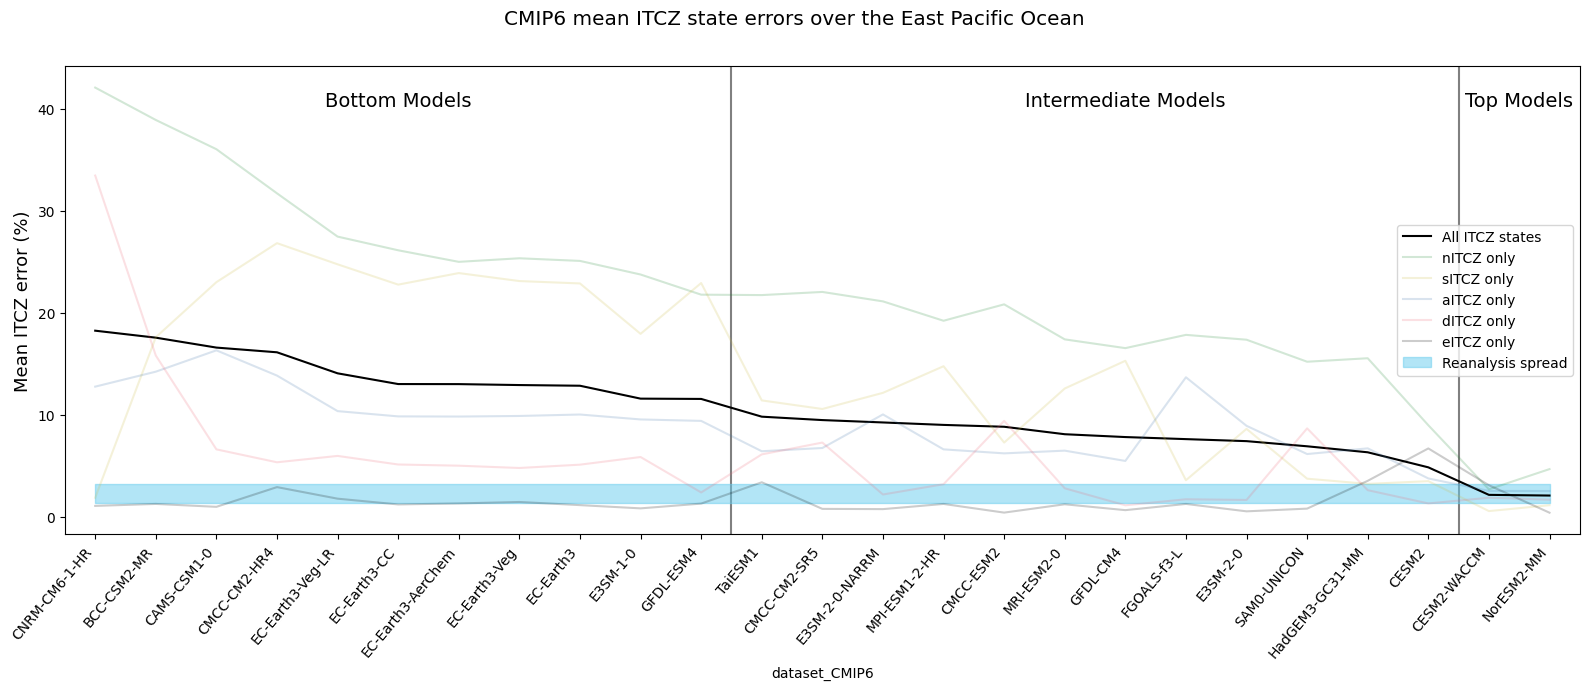

In [84]:
npan = 1

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(16, 7), tight_layout='true')
fig.suptitle(r'CMIP6 mean ITCZ state errors over the '+region_str,fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    ax1 = ( prc_ITCZ_CMIP6_errors_all_plt ).plot(color='k',label='All ITCZ states')
    for istate in range(0,nitcz_state):
        ax2 = ( prc_ITCZ_CMIP6_errors_plt[:,istate] ).plot(alpha=0.2, color=colors_color_blind[istate],label=itcz_state[istate]+' only')
        plt.title(' ')
    plt.axvline(10.5,color='grey',zorder=-1)
    plt.axvline(22.5,color='grey',zorder=-1)

    plt.fill_between(prc_ITCZ_CMIP6_errors_plt['dataset_CMIP6'],prc_ITCZ_reana_errors_min,prc_ITCZ_reana_errors_max, color='#66CCEE', alpha=0.5, zorder=-1, label='Reanalysis spread')
    plt.ylabel('Mean ITCZ error (%)',fontsize=13)
    plt.legend(loc=5)
    
    # place a text box in upper left in axes coords
    ax.text(5., ymax, 'Bottom Models', fontsize=14, horizontalalignment='center', verticalalignment='center')
    ax.text(17., ymax, 'Intermediate Models', fontsize=14, horizontalalignment='center', verticalalignment='center')
    ax.text(23.5, ymax, 'Top Models', fontsize=14, horizontalalignment='center', verticalalignment='center')
    
    plt.xlim(-.5,24.5)
    #plt.ylim(0,30)
    plt.xticks(rotation=50,ha='right')
    
plt.savefig(figfolder+figname2,bbox_inches="tight",transparent=False,dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


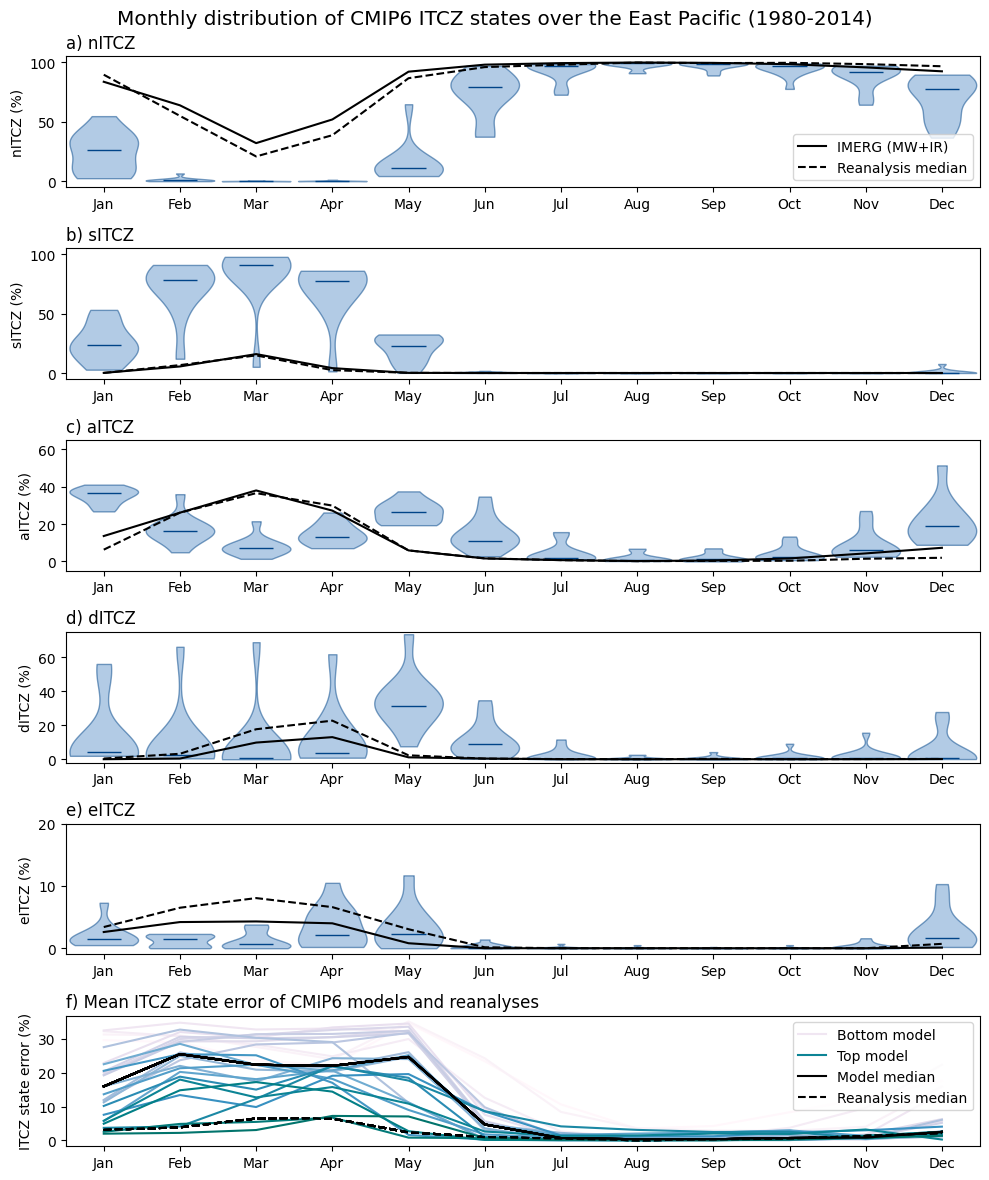

In [100]:
npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of CMIP6 models and reanalyses', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(prc_nITCZ_xr[1:,:].sel(dataset=model_bot),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_nITCZ[0,:],color='k',label='IMERG (MW+IR)')
        ax3 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.legend(loc=4)
        plt.ylabel('nITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(prc_sITCZ_xr[1:,:].sel(dataset=model_bot),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_sITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('sITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(prc_aITCZ_xr[1:,:].sel(dataset=model_bot),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_aITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('aITCZ (%)')
        plt.ylim(-5,65)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(prc_dITCZ_xr[1:,:].sel(dataset=model_bot),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_dITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('dITCZ (%)')
        plt.ylim(-2,75)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(prc_eITCZ_xr[1:,:].sel(dataset=model_bot),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_eITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('eITCZ (%)')
        plt.ylim(-1,20)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
plt.savefig(figfolder+'ITCZ_state_'+region+'_CMIP6_stats_bot.pdf',bbox_inches="tight",transparent=False,dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


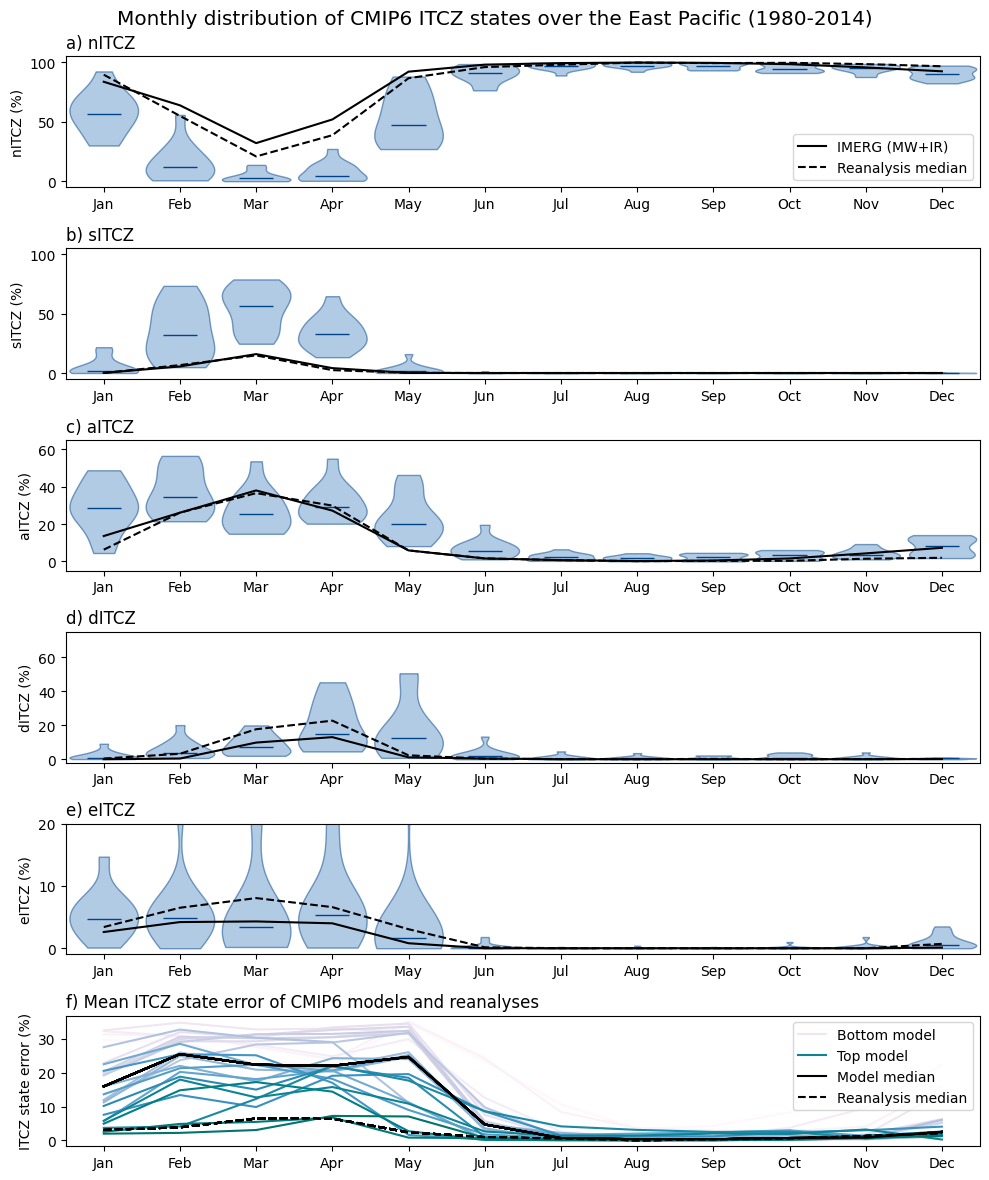

In [114]:
npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of CMIP6 models and reanalyses', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(prc_nITCZ_xr[1:,:].sel(dataset=model_intermed),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_nITCZ[0,:],color='k',label='IMERG (MW+IR)')
        ax3 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.legend(loc=4)
        plt.ylabel('nITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(prc_sITCZ_xr[1:,:].sel(dataset=model_intermed),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_sITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('sITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(prc_aITCZ_xr[1:,:].sel(dataset=model_intermed),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_aITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('aITCZ (%)')
        plt.ylim(-5,65)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(prc_dITCZ_xr[1:,:].sel(dataset=model_intermed),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_dITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('dITCZ (%)')
        plt.ylim(-2,75)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(prc_eITCZ_xr[1:,:].sel(dataset=model_intermed),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_eITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('eITCZ (%)')
        plt.ylim(-1,20)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
plt.savefig(figfolder+'ITCZ_state_'+region+'_CMIP6_stats_intermed.pdf',bbox_inches="tight",transparent=False,dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


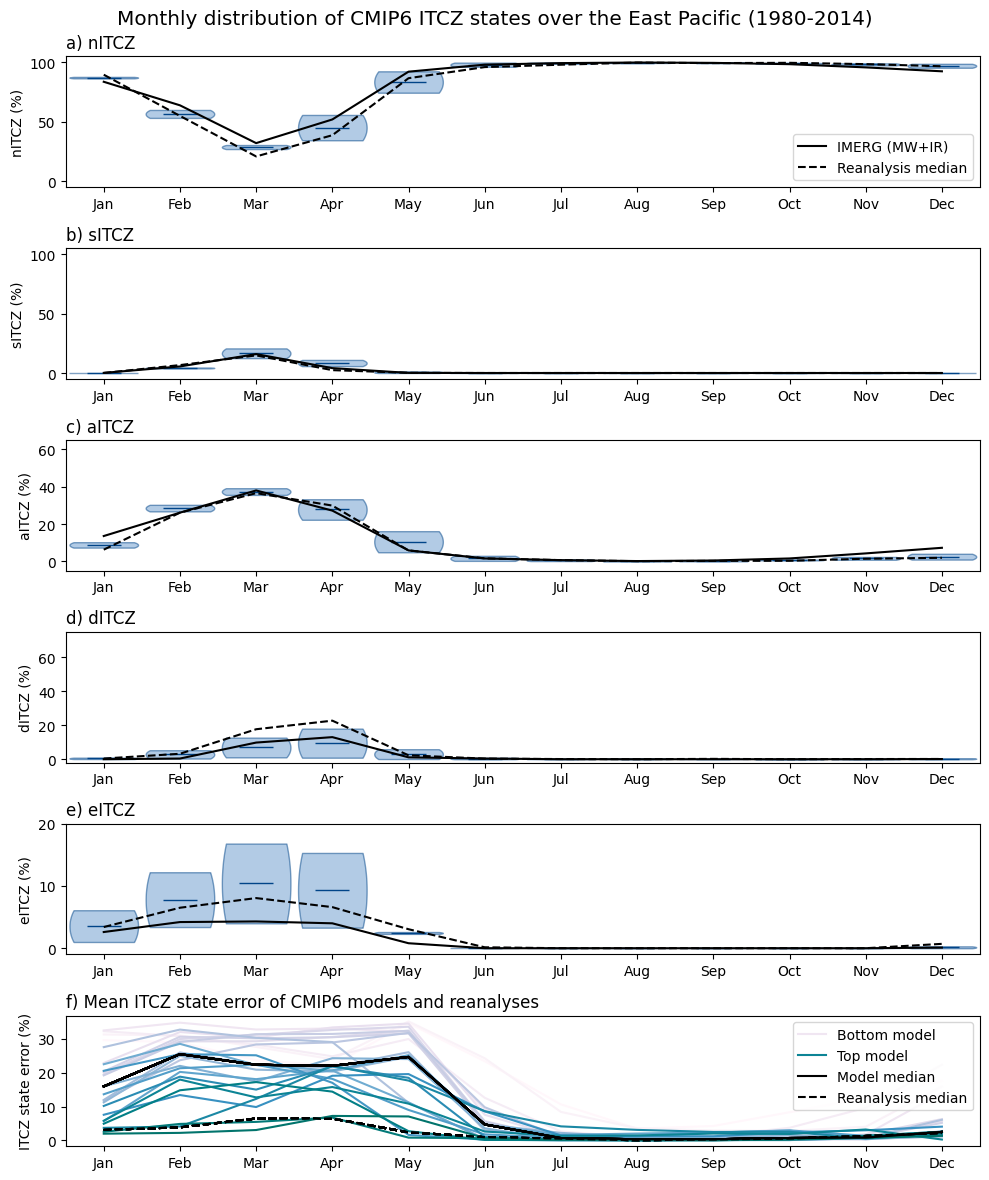

In [115]:
npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of CMIP6 models and reanalyses', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(prc_nITCZ_xr[1:,:].sel(dataset=model_top),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_nITCZ[0,:],color='k',label='IMERG (MW+IR)')
        ax3 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.legend(loc=4)
        plt.ylabel('nITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(prc_sITCZ_xr[1:,:].sel(dataset=model_top),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_sITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('sITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(prc_aITCZ_xr[1:,:].sel(dataset=model_top),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_aITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('aITCZ (%)')
        plt.ylim(-5,65)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(prc_dITCZ_xr[1:,:].sel(dataset=model_top),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_dITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('dITCZ (%)')
        plt.ylim(-2,75)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(prc_eITCZ_xr[1:,:].sel(dataset=model_top),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_eITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('eITCZ (%)')
        plt.ylim(-1,20)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
plt.savefig(figfolder+'ITCZ_state_'+region+'_CMIP6_stats_top.pdf',bbox_inches="tight",transparent=False,dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


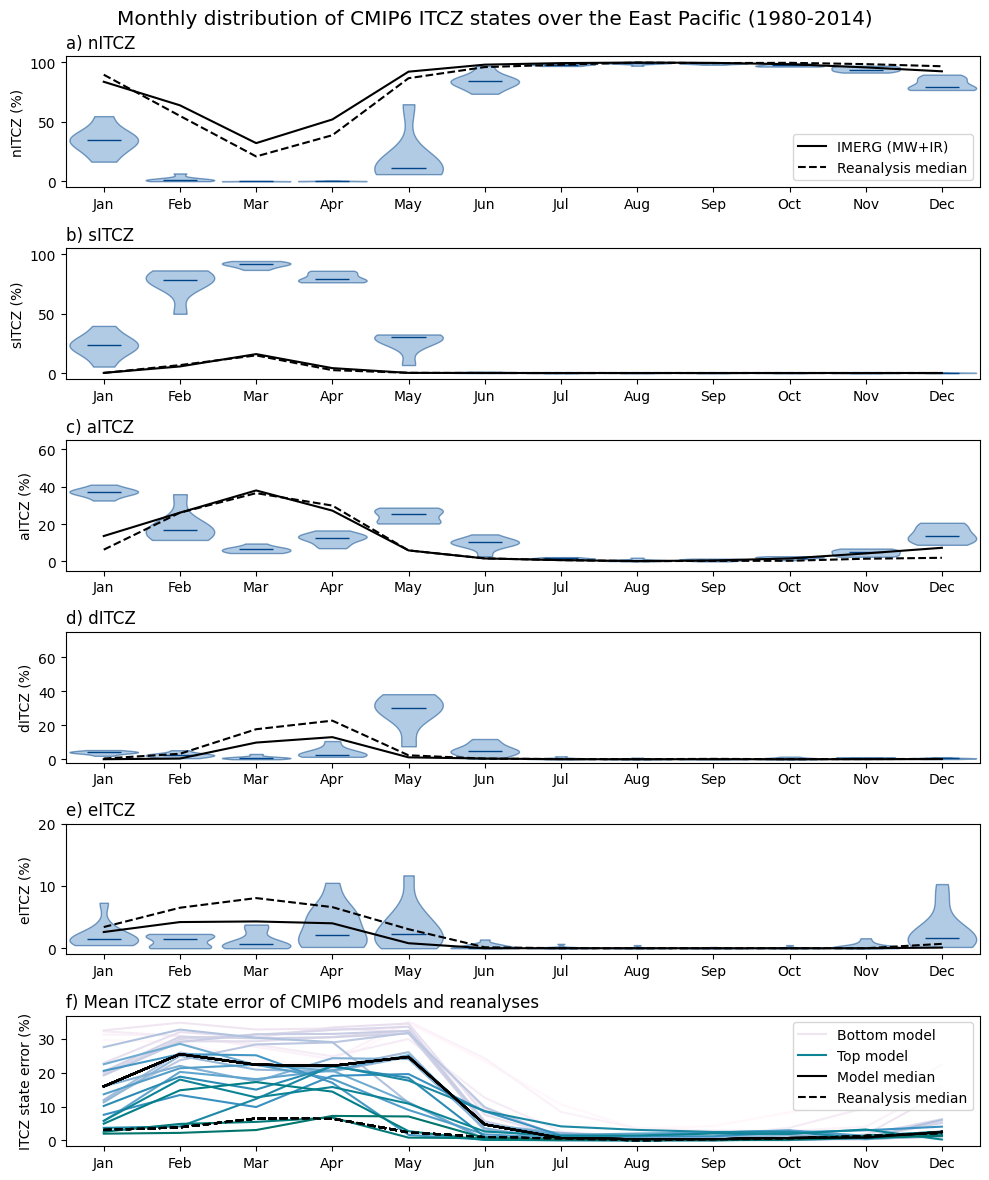

In [110]:
npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of CMIP6 models and reanalyses', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(prc_nITCZ_xr[1:,:].sel(dataset=model_shoulder),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_nITCZ[0,:],color='k',label='IMERG (MW+IR)')
        ax3 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.legend(loc=4)
        plt.ylabel('nITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(prc_sITCZ_xr[1:,:].sel(dataset=model_shoulder),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_sITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('sITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(prc_aITCZ_xr[1:,:].sel(dataset=model_shoulder),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_aITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('aITCZ (%)')
        plt.ylim(-5,65)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(prc_dITCZ_xr[1:,:].sel(dataset=model_shoulder),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_dITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('dITCZ (%)')
        plt.ylim(-2,75)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(prc_eITCZ_xr[1:,:].sel(dataset=model_shoulder),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_eITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('eITCZ (%)')
        plt.ylim(-1,20)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
#plt.savefig(figfolder+'ITCZ_state_'+region+'_CMIP6_stats_intermed.pdf',bbox_inches="tight",transparent=False,dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


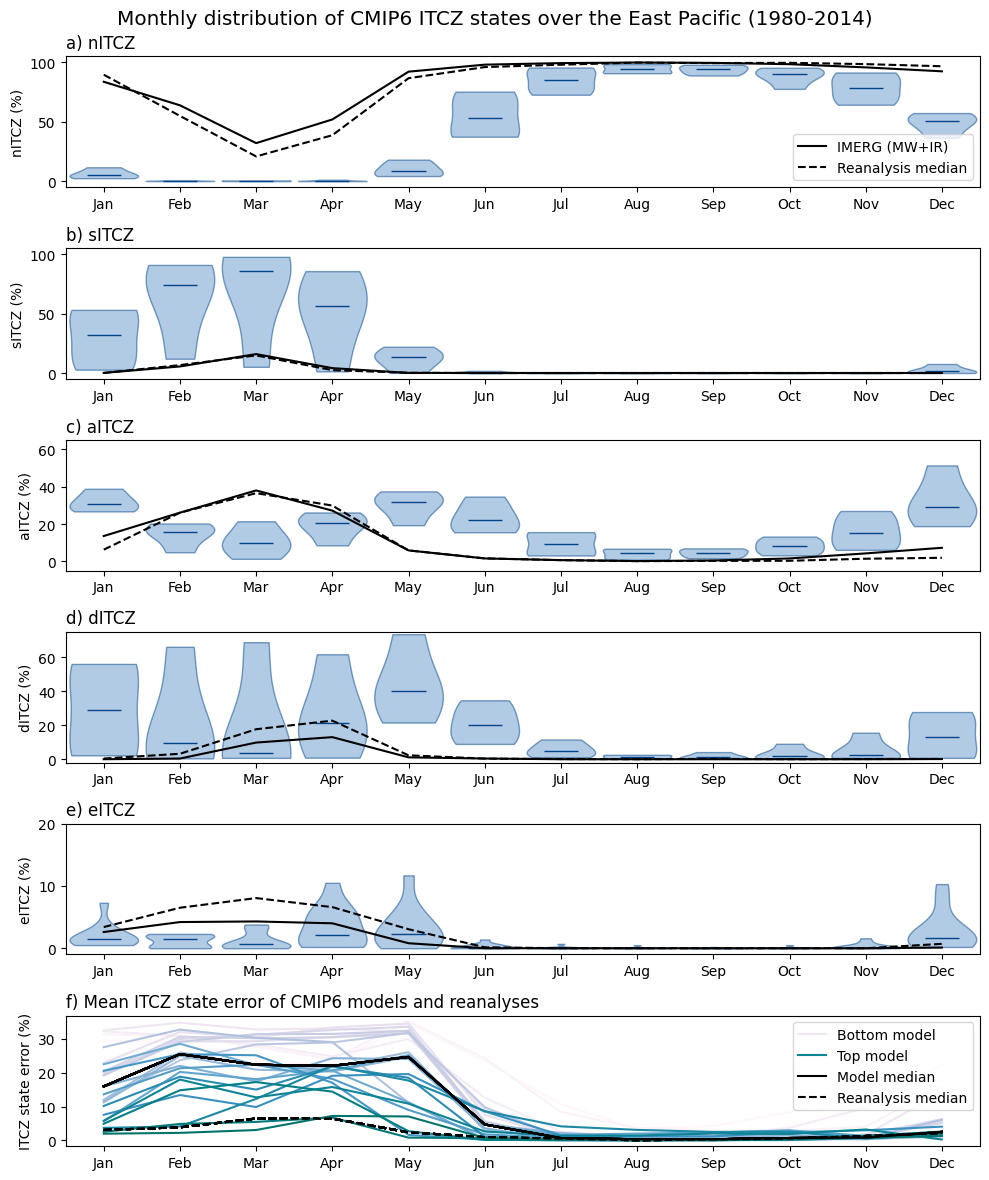

In [113]:
npan = 6

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of CMIP6 models and reanalyses', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.violinplot(prc_nITCZ_xr[1:,:].sel(dataset=model_worst),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_nITCZ[0,:],color='k',label='IMERG (MW+IR)')
        ax3 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.legend(loc=4)
        plt.ylabel('nITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.violinplot(prc_sITCZ_xr[1:,:].sel(dataset=model_worst),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_sITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('sITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.violinplot(prc_aITCZ_xr[1:,:].sel(dataset=model_worst),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_aITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('aITCZ (%)')
        plt.ylim(-5,65)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.violinplot(prc_dITCZ_xr[1:,:].sel(dataset=model_worst),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)

        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_dITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('dITCZ (%)')
        plt.ylim(-2,75)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.violinplot(prc_eITCZ_xr[1:,:].sel(dataset=model_worst),showmeans=False,showmedians=True,showextrema=False,widths=0.9)
            
        # Make the violin body blue with a red border:
        for vp in ax1['bodies']:
                vp.set_facecolor('#6699CC')
                vp.set_edgecolor('#004488')
                vp.set_linewidth(1)
                vp.set_alpha(0.5)
    
        # Set the color of the median lines
        vp = ax1['cmedians']
        vp.set_edgecolor('#004488')
        vp.set_linewidth(1)
        
        ax2 = ax.plot(month,prc_eITCZ[0,:],color='k',label='TMPA')
        ax3 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        plt.ylabel('eITCZ (%)')
        plt.ylim(-1,20)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(0.5,12.5)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

figfolder = '/home/alex.gonzalez/CMIP6_ITCZ_state_project/figures/methods_paper/revision/'
#plt.savefig(figfolder+'ITCZ_state_'+region+'_CMIP6_stats_worst.pdf',bbox_inches="tight",transparent=False,dpi=150)

In [143]:
group1_xr = model_top
group2_xr = model_intermed
group3_xr = model_bot

g1_name = 'Top models median'
g2_name = 'Intermediate models median'
g3_name = 'Bottom models median'

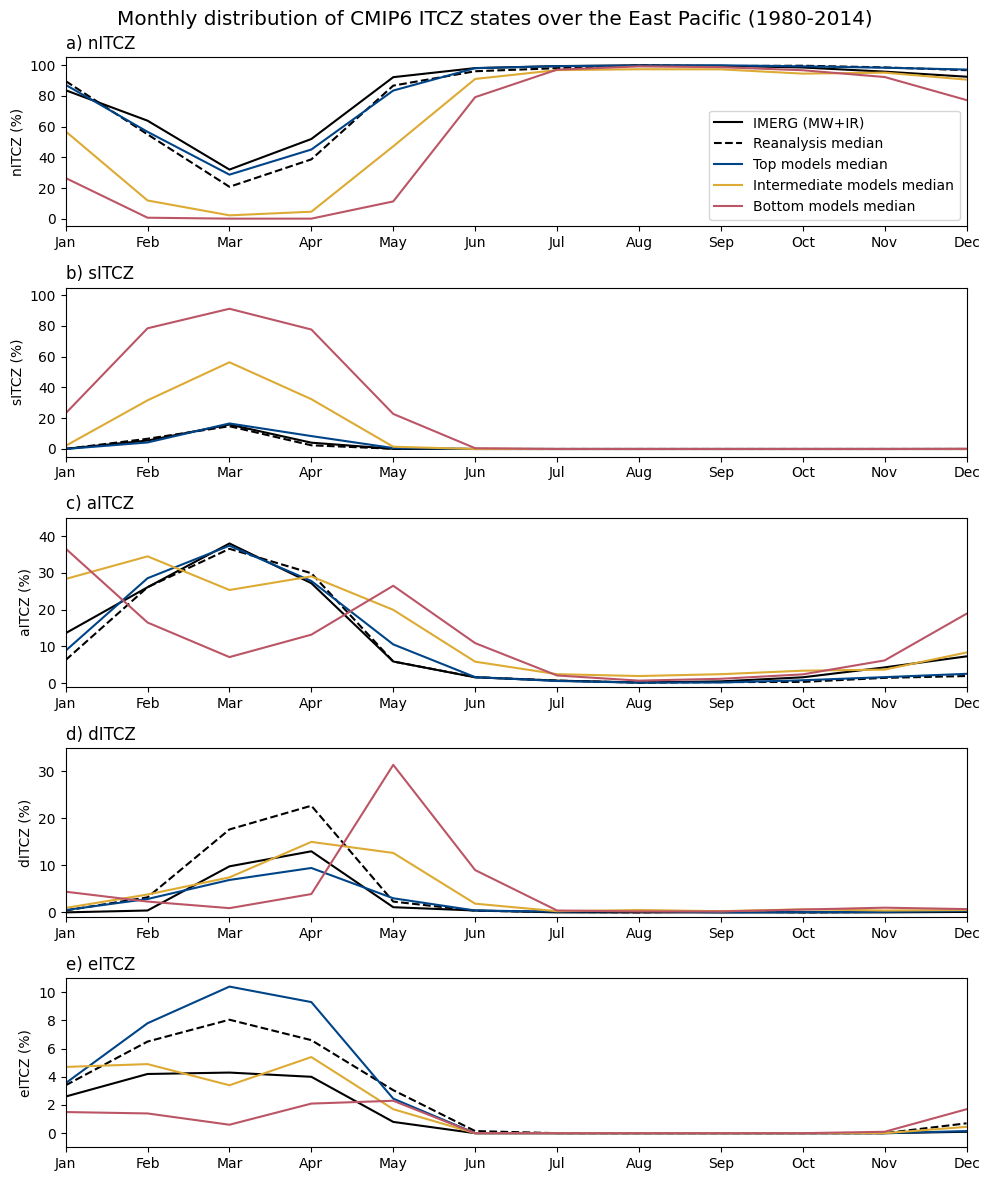

In [150]:
npan = 5

# all of the sizes are double the size they'll be in the paper 
fig = plt.figure(figsize=(10, 12), tight_layout='true')
fig.suptitle(r'Monthly distribution of CMIP6 ITCZ states over the '+region_str+' (1980-2014)',fontsize='x-large')

for jj in range(0,npan,1):
    ax = fig.add_subplot(npan,1,jj+1)
    #axs.set_ylim(0,105)

    if jj == 5:
        for ll in range(0,ndataset-1,1):
            if ll == 0+3:
                mylabel = 'Bottom model'
                med_label = None
                re_med_label = None
            elif ll == ndataset-2-3:
                mylabel = 'Top model'
                med_label = 'Model median'
                re_med_label = 'Reanalysis median'
            else:
                mylabel = None
                med_label = None
                re_med_label = None
            ax1 = plt.plot(month,prc_ITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            #ax1 = plt.plot(month,prc_sdITCZ_anom_abs_sort[ll,:], color=colors[ll],label=mylabel)
            
            ax2 = plt.plot(month,prc_ITCZ_anom_abs_median, color='k',label=med_label)
            ax3 = plt.plot(month,prc_abs_reanal_median,color='k',linestyle='--',label=re_med_label)
            plt.legend(loc=1)
        plt.ylabel('ITCZ state error (%)')
        ax.set_title('f) Mean ITCZ state error of all CMIP6 models', loc='left')
    
    if jj == 0:
        # plot violin plot
        ax1 = ax.plot(month,prc_nITCZ_xr.sel(dataset=('IMERG')),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_nITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        ax3 = ax.plot(month,prc_nITCZ_xr.sel(dataset=group1_xr).median(dim=('dataset')),color='#004488',label=g1_name)
        ax4 = ax.plot(month,prc_nITCZ_xr.sel(dataset=group2_xr).median(dim=('dataset')),color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,prc_nITCZ_xr.sel(dataset=group3_xr).median(dim=('dataset')),color='#BB5566',label=g3_name)
        
        plt.legend(loc=4)
        plt.ylabel('nITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('a) nITCZ', loc='left')

    if jj == 1:
        # plot violin plot
        ax1 = ax.plot(month,prc_sITCZ_xr.sel(dataset=('IMERG')),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_sITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        ax3 = ax.plot(month,prc_sITCZ_xr.sel(dataset=group1_xr).median(dim=('dataset')),color='#004488',label=g1_name)
        ax4 = ax.plot(month,prc_sITCZ_xr.sel(dataset=group2_xr).median(dim=('dataset')),color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,prc_sITCZ_xr.sel(dataset=group3_xr).median(dim=('dataset')),color='#BB5566',label=g3_name)
        
        plt.ylabel('sITCZ (%)')
        plt.ylim(-5,105)
        ax.set_title('b) sITCZ', loc='left')

    if jj == 2:
        # plot violin plot
        ax1 = ax.plot(month,prc_aITCZ_xr.sel(dataset=('IMERG')),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_aITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        ax3 = ax.plot(month,prc_aITCZ_xr.sel(dataset=group1_xr).median(dim=('dataset')),color='#004488',label=g1_name)
        ax4 = ax.plot(month,prc_aITCZ_xr.sel(dataset=group2_xr).median(dim=('dataset')),color='#DDAA33',label=g2_name)
        ax5 = ax.plot(month,prc_aITCZ_xr.sel(dataset=group3_xr).median(dim=('dataset')),color='#BB5566',label=g3_name)
        
        plt.ylabel('aITCZ (%)')
        plt.ylim(-1,45)
        ax.set_title('c) aITCZ', loc='left')
        
    if jj == 3:
        # plot violin plot
        ax1 = ax.plot(month,prc_dITCZ_xr.sel(dataset=('IMERG')),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_dITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        ax3 = ax.plot(month,prc_dITCZ_xr.sel(dataset=group1_xr).median(dim=('dataset')),color='#004488',label='Top models median')
        ax4 = ax.plot(month,prc_dITCZ_xr.sel(dataset=group2_xr).median(dim=('dataset')),color='#DDAA33',label='Shoulder models median')
        ax5 = ax.plot(month,prc_dITCZ_xr.sel(dataset=group3_xr).median(dim=('dataset')),color='#BB5566',label='sITCZ models median')
        
        plt.ylabel('dITCZ (%)')
        plt.ylim(-1,35)
        ax.set_title('d) dITCZ', loc='left')
        
    if jj == 4:
        # plot violin plot
        ax1 = ax.plot(month,prc_eITCZ_xr.sel(dataset=('IMERG')),color='k',label='IMERG (MW+IR)')
        ax2 = ax.plot(month,prc_eITCZ_reana_xr.median(dim='dataset'),color='k',linestyle='--',label='Reanalysis median')
        ax3 = ax.plot(month,prc_eITCZ_xr.sel(dataset=group1_xr).median(dim=('dataset')),color='#004488',label='Top models median')
        ax4 = ax.plot(month,prc_eITCZ_xr.sel(dataset=group2_xr).median(dim=('dataset')),color='#DDAA33',label='Shoulder models median')
        ax5 = ax.plot(month,prc_eITCZ_xr.sel(dataset=group3_xr).median(dim=('dataset')),color='#BB5566',label='sITCZ models median')
        
        plt.ylabel('eITCZ (%)')
        plt.ylim(-1,11)
        ax.set_title('e) eITCZ', loc='left')
    
    #ax.set_title('Jan-May mean error = '+str(prc_anom_abs_median_fmt[jj])+'%', loc='right')
    plt.xlim(1,12)
    #plt.xlabel('month')
    ax.set_xticks(month,labels=mon_str)

plt.savefig(figfolder+figname3,bbox_inches="tight",transparent=False,dpi=150)